In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from keras.models import load_model
from keras.callbacks import EarlyStopping
from h5py._hl.dataset import sel2

2023-10-19 15:02:26.565946: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 15:02:27.096305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 15:02:27.096373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 15:02:27.099771: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 15:02:27.410393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 15:02:27.413925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [20]:
#Functions

def data_to_Input(data):
        
    data_3d = np.array([])
    data_3d = data[np.newaxis,:,:]
    data_3d = data_3d.transpose((1,2,0))
    
    return data_3d

def BP_dat_plot(dat, title):
    dist_data_sbp = dat[:, 0]
    dist_data_dbp = dat[:, 1]

    sbp_mean = np.mean(dist_data_sbp)
    dist_data_sbp = dist_data_sbp.astype(int)

    dbp_mean = np.mean(dist_data_dbp)
    dist_data_dbp = dist_data_dbp.astype(int)

    sbp_std = np.std(dat[:, 0])
    dbp_std = np.std(dat[:, 1])

    fig_bp_dist, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

    axs[0].hist(dist_data_sbp, bins=range(min(dist_data_sbp), max(dist_data_sbp)+2))
    axs[0].set_title(title + ' SBP')
    axs[0].axvline(x=sbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=sbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=sbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlabel('SBP value [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(sbp_mean, sbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(dist_data_dbp, bins=range(min(dist_data_dbp), max(dist_data_dbp)+2))
    axs[1].set_title(title + ' DBP')
    axs[1].axvline(x=dbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=dbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=dbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlabel('DBP value [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(dbp_mean, dbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  
  # absolute error
def error_plot(y_test, y_pred):

    y_test_2d = y_test[:,:,0]
    abs_error_sbp = y_test_2d.T[:,0] - y_pred[:,0]
    abs_error_dbp = y_test_2d.T[:,1] - y_pred[:,1]

    aberr_mean_sbp = np.mean(abs_error_sbp)
    aberr_mean_dbp = np.mean(abs_error_dbp)

    aberr_std_sbp = np.std(abs_error_sbp)
    aberr_std_dbp = np.std(abs_error_dbp)

    abs_error_sbp_int = abs_error_sbp.astype(int)
    abs_error_dbp_int = abs_error_dbp.astype(int)

    fig_abs_error, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(abs_error_sbp_int, bins=range(min(abs_error_sbp_int), max(abs_error_sbp_int)+2))
    axs[0].set_title('BP-CRNN-50 SBP Error')
    axs[0].axvline(x=aberr_mean_sbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp - aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp + aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlim([-10, 60])
    axs[0].set_xlabel('error [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_sbp, aberr_std_sbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(abs_error_dbp_int, bins=range(min(abs_error_dbp_int), max(abs_error_dbp_int)+2))
    axs[1].set_title('BP-CRNN-50 DBP Error')
    axs[1].axvline(x=aberr_mean_dbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp - aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp + aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlim([-20, 20])
    axs[1].set_xlabel('error [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_dbp, aberr_std_dbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  

def bland_altman_plot(data1, data2, *args, **kwargs):
    """
    Bland-Altman plot to compare two sets of measurements.

    Parameters
    ----------
    data1 : array_like
        The first set of measurements.
    data2 : array_like
        The second set of measurements.
    args : positional arguments
        Additional positional arguments to be passed to plt.scatter().
    kwargs : keyword arguments
        Additional keyword arguments to be passed to plt.scatter().

    Returns
    -------
    fig, ax : tuple
        The matplotlib figure and axes objects.
    """
    data1 = data1.T
    data2 = data2.T

    mean = np.mean([data1, data2], axis=0)
    diff = (data1 - data2)
    md = np.mean(diff, axis=1)
    sd = np.std(diff, axis=1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 10), tight_layout=False)

    ax[0].scatter(mean[0], diff[0], *args, **kwargs, alpha = 0.5)
    ax[0].axhline(md[0], color='gray', linestyle='--')
    ax[0].axhline(md[0] + 1.96*sd[0], color='red', linestyle='--')
    ax[0].axhline(md[0] - 1.96*sd[0], color='red', linestyle='--')
    ax[0].set_xlim([data1[0].min(), data1[0].max()])
    ax[0].set_ylim([-30, 30])
    ax[0].set_xlabel('Mean', fontsize = 20)
    ax[0].set_ylabel('Difference', fontsize = 20)
    ax[0].set_title('SBP Bland-Altman Plot', fontsize = 20)

    ax[1].scatter(mean[1], diff[1], *args, **kwargs, alpha = 0.5)
    ax[1].axhline(md[1], color='gray', linestyle='--')
    ax[1].axhline(md[1] + 1.96*sd[1], color='red', linestyle='--')
    ax[1].axhline(md[1] - 1.96*sd[1], color='red', linestyle='--')
    ax[1].set_xlim([data1[1].min(), data1[1].max()])
    ax[1].set_ylim([-30,30])
    ax[1].set_xlabel('Mean', fontsize = 20)
    ax[1].set_ylabel('Difference', fontsize = 20)
    ax[1].set_title('DBP Bland-Altman Plot', fontsize = 20)

    return fig, ax

def pred_plot(test_dat, pred_dat, SBP_Coef, DBP_Coef):
    
    sbp_min = test_dat[:, 0].min()
    sbp_max = test_dat[:, 0].max()
    dbp_min = test_dat[:, 1].min()
    dbp_max = test_dat[:, 1].max()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), tight_layout=False)
    
    ax[0].plot(test_dat[:, 0], np.poly1d(np.polyfit(test_dat[:, 0], pred_dat[:,0], 1))(test_dat[:, 0]), color='red')
    ax[0].scatter(test_dat[:,0], pred_dat[:,0], c='blue', alpha = 0.2)
    ax[0].text(0.95, 0.95, 'Pearson-R = %.2f'%round(SBP_Coef,2), transform=ax[0].transAxes,
    fontsize=20, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax[0].scatter(test_dat[:,0], pred_dat[:,0], c='blue', alpha = 0.5)
    ax[0].set_xlim([sbp_min-10, sbp_max+10])
    ax[0].set_ylim([sbp_min-10, sbp_max+10])
    ax[0].set_xlabel('True SBP', fontsize = 20)
    ax[0].set_ylabel('Estimated SBP', fontsize = 20)
    ax[0].set_title('SBP', fontsize = 20)
    
    ax[1].plot(test_dat[:, 1], np.poly1d(np.polyfit(test_dat[:, 1], pred_dat[:,1], 1))(test_dat[:, 1]), color='red')
    ax[1].scatter(test_dat[:,1], pred_dat[:,1], c='blue', alpha = 0.2)
    ax[1].text(0.95, 0.95, 'Pearson-R = %.2f'%round(DBP_Coef,2), transform=ax[1].transAxes,
    fontsize=20, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax[1].scatter(test_dat[:,1], pred_dat[:,1], c='blue', alpha = 0.5)
    ax[1].set_xlim([dbp_min-10, dbp_max+10])
    ax[1].set_ylim([dbp_min-10, dbp_max+10])
    ax[1].set_xlabel('True DBP', fontsize = 20)
    ax[1].set_ylabel('Estimated DBP', fontsize = 20)
    ax[1].set_title('DBP', fontsize = 20)
    
    return fig, ax

In [3]:
model = load_model("/media/yoonchul/T7/lab/Research/ppg_nibp/Models/Ex_3/p004837_360.0TL_model.h5")
data = np.load("/media/yoonchul/T7/lab/Research/ppg_nibp/Dataset/Ex_1/Processed_dataset/Group_1/processed_data_p004837.npz")

In [4]:
_, x_test, _, y_test = train_test_split(data['x'], data['y'], train_size = 0.5, test_size = 0.1)

23/23 [==============================] - 0s 12ms/step
MAE for SBP: 4.47
MAE for DBP: 2.75


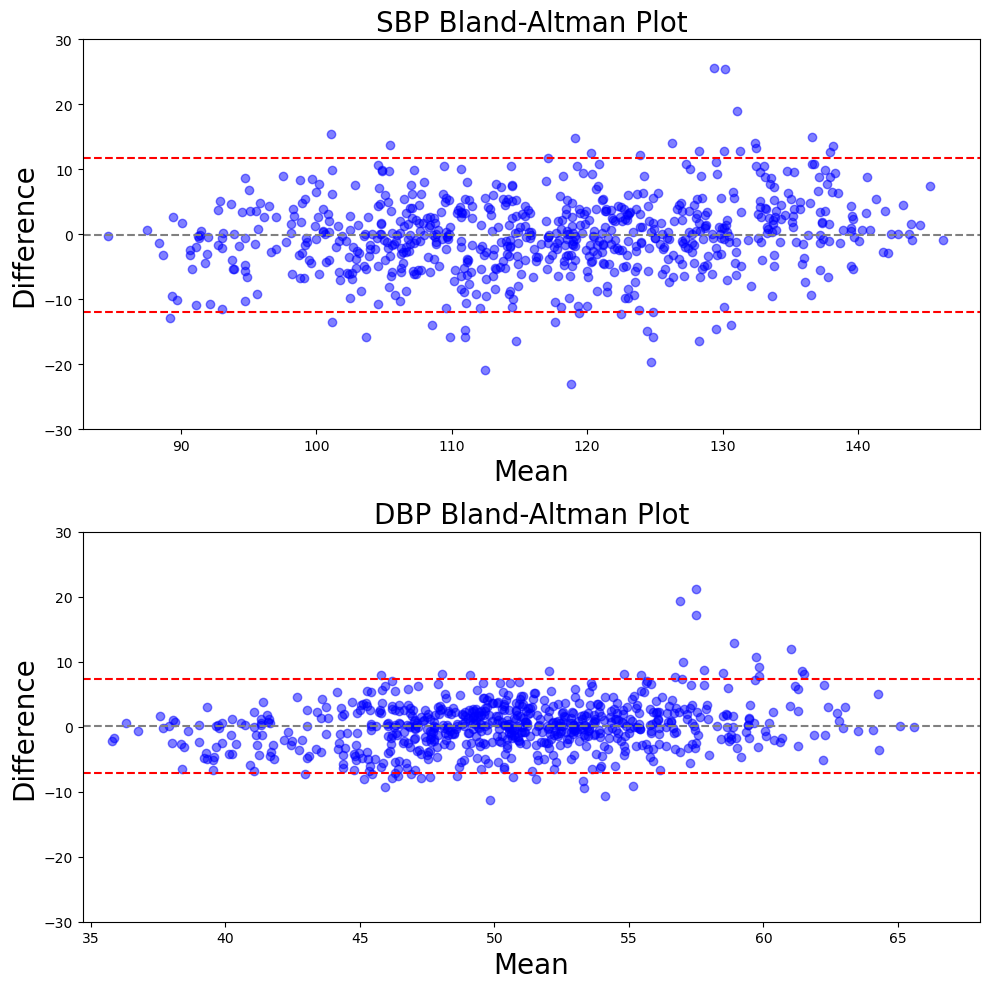

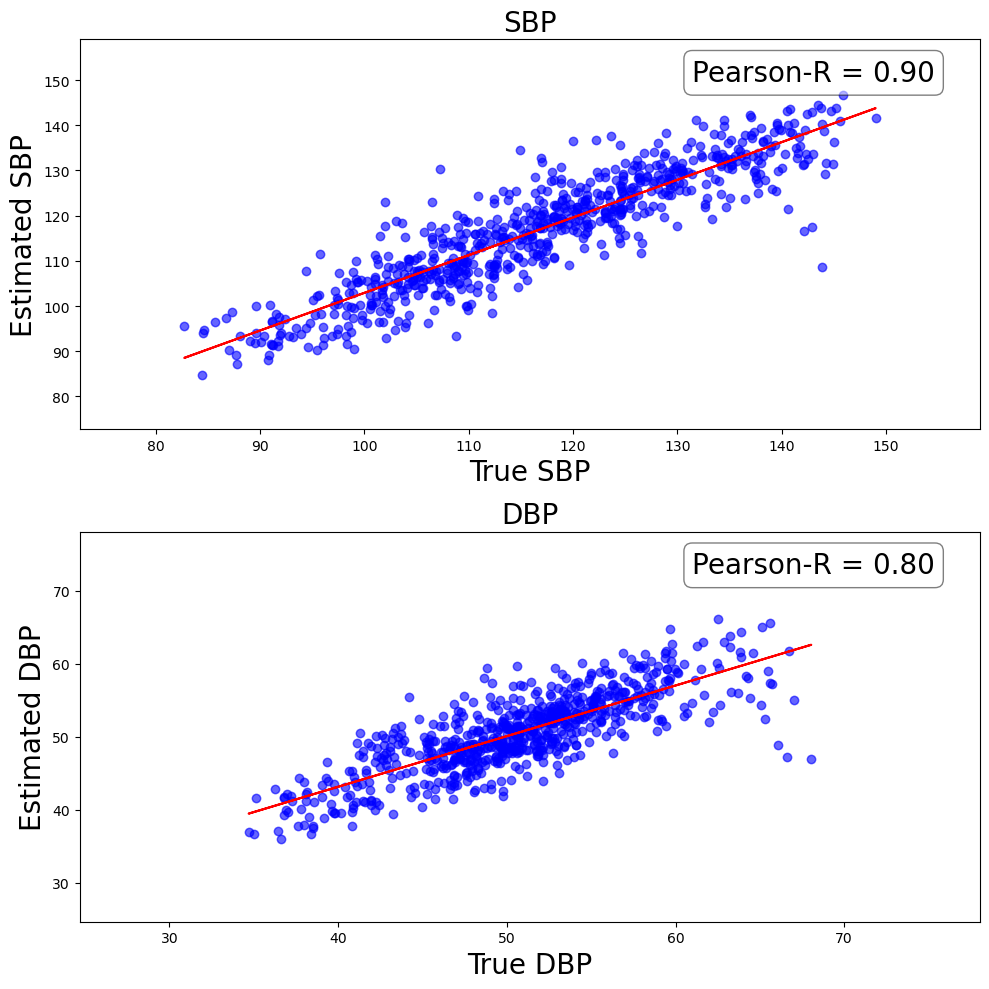

In [21]:
# Predict on test set
y_pred = model.predict(x_test)

SBP_Coef = round(np.corrcoef(y_test[:, 0], y_pred[:,0])[0, 1],2)
DBP_Coef = round(np.corrcoef(y_test[:, 1], y_pred[:,1])[0, 1],2)

print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], y_pred[:,0])))
print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], y_pred[:,1])))

fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, color='blue', marker='o')
fig_ac, ax_ac = pred_plot(y_test, y_pred, SBP_Coef, DBP_Coef)

Text(0.5, 0, 'samples')

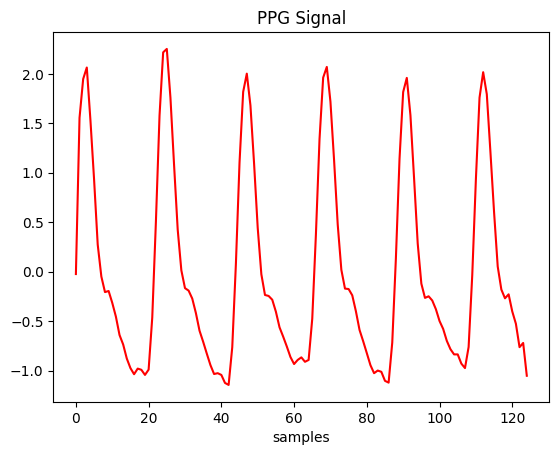

In [74]:
# 수집한 ppg 데이터 시각화

plt.plot(x_train[119, :, 0], color='red')
plt.title("PPG Signal")
plt.xlabel("samples")